In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from nltk.corpus import stopwords

from nltk.stem.porter import *
from nltk.stem.lancaster import *
from nltk.stem.wordnet import *

In [4]:
sns.set(style='whitegrid', palette='GnBu_d', font_scale=1.5, rc={'figure.figsize':(10,6)})

# Pandas DataFrame - working with text data

In [5]:
# https://raw.githubusercontent.com/ZhibingChen/DM-Reuters21578/master/reutersCSV.csv
df = pd.read_csv('reutersCSV.csv', encoding='iso-8859-1', keep_default_na=False)

In [6]:
# size of the data set
df.index.size

21578

In [7]:
# list of columns
df.columns

Index(['pid', 'fileName', 'purpose', 'topic.acq', 'topic.alum',
       'topic.austdlr', 'topic.austral', 'topic.barley', 'topic.bfr',
       'topic.bop',
       ...
       'topic.tung', 'topic.tung.oil', 'topic.veg.oil', 'topic.wheat',
       'topic.wool', 'topic.wpi', 'topic.yen', 'topic.zinc', 'doc.title',
       'doc.text'],
      dtype='object', length=140)

In [8]:
df.sample(3)

,pid,fileName,purpose,topic.acq,topic.alum,topic.austdlr,topic.austral,topic.barley,topic.bfr,topic.bop,...,topic.tung,topic.tung.oil,topic.veg.oil,topic.wheat,topic.wool,topic.wpi,topic.yen,topic.zinc,doc.title,doc.text
20706,20707,20,test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,MENTOR CORP (MNTR.O) TO REPURCHASE SHARES,Mentor Corp said its board of directors has au...
5852,5853,5,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,BANK OF JAPAN TO SELL 300 BILLION YEN IN BILLS,The Bank of Japan will sell 300 billion yen of...
10121,10122,10,train,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,COCOA CHAIRMAN WORKS TOWARDS BUFFER COMPROMISE,"International Cocoa Organization's, ICCO, coun..."


In [9]:
# seems like pid is a uqique document id, lets check it out:
print('df rows count:', df.index.size, 'vs df.pid unique values count: ', df.pid.nunique())

df rows count: 21578 vs df.pid unique values count:  21578


In [10]:
# better to use pid as index then:
df = df.set_index('pid')

In [11]:
# select columns with topic markers using the exposed String class methods via df[columns].str:
topic_cols = df.columns.str.find('topic')==0

In [12]:
# create 'docs' subset with document columns only:
docs = df.loc[:,~topic_cols]

In [13]:
# and 'topics' subset with only topic marker columns:
topics =  (
    df.loc[:,topic_cols]
      .rename(columns=lambda x: x.replace('topic.', ''))
      .rename_axis('topic', axis=1)
     
)

In [14]:
docs.sample(3)

,fileName,purpose,doc.title,doc.text
pid,,,,
18466,18,test,CHINA MOVES TO STABILISE WORLD TUNGSTEN PRICES,China is moving to stabilise world prices of t...
20270,20,test,NORWAY BOOSTS OIL OUTPUT BY 22 PCT IN SEPTEMBER,Norway's September oil output rose by 22.2 pct...
16297,16,test,O'SULLIVAN CORP &lt;OSL> 1ST QTR NET,"Shr 28 cts vs 32 cts Net 2,823,000 vs 3,21..."


In [15]:
topics.sample(3)

topic,acq,alum,austdlr,austral,barley,bfr,bop,can,carcass,castor.meal,...,tin,trade,tung,tung.oil,veg.oil,wheat,wool,wpi,yen,zinc
pid,,,,,,,,,,,,,,,,,,,,,
13579,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18844,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# number of topics:
topics.columns.size

135

### Some basic analysis of the data set

In [17]:
# Document count per topic:
(topics.stack()
 .reset_index()
 .groupby('topic')[0].sum()
 .sort_values(0, ascending=False)
 .head(10)
)

topic
earn        3987
acq         2448
money.fx     801
crude        634
grain        628
trade        551
interest     513
wheat        306
ship         305
corn         253
Name: 0, dtype: int64

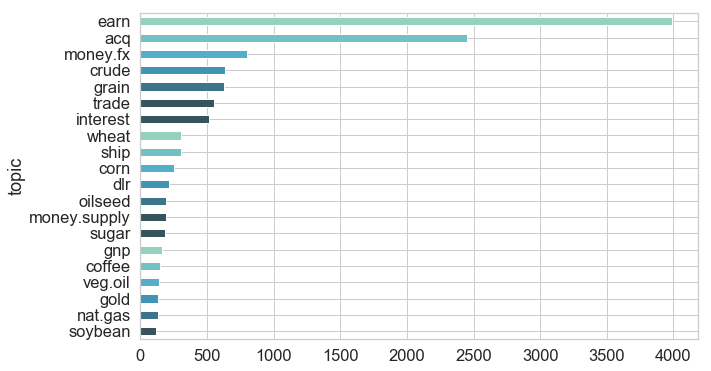

In [18]:
topics.stack().reset_index().groupby('topic')[0].sum().sort_values().tail(20).plot(kind='barh')

list

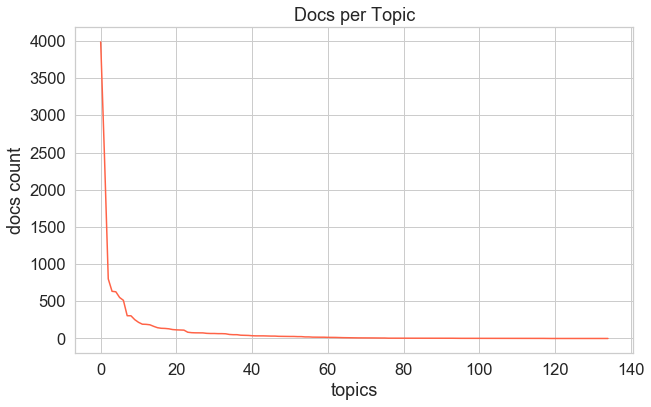

In [19]:
# the same with the long tail:
type((topics.stack()
 .reset_index()
 .groupby('topic')[0].sum()
 .sort_values(ascending=False)
 .plot(kind='line', color='tomato', use_index=False, title='Docs per Topic', logy=False).set(xlabel='topics', ylabel='docs count')
))

In [20]:
# How many topics one document may have?
(topics
 .sum(axis=1)
 .rename('topics_per_doc')
 .to_frame()
 .groupby('topics_per_doc').size().rename('docs_num')   
 .to_frame()
 .assign(percent = lambda x: 100*x.docs_num/x.docs_num.sum())
 .style.format({
     'percent': '{:,.2f}'.format
 })
)

,docs_num,percent
topics_per_doc,,
0,10238,47.45
1,9470,43.89
2,1339,6.21
3,310,1.44
4,101,0.47
5,63,0.29
6,25,0.12
7,10,0.05
8,9,0.04


[None]

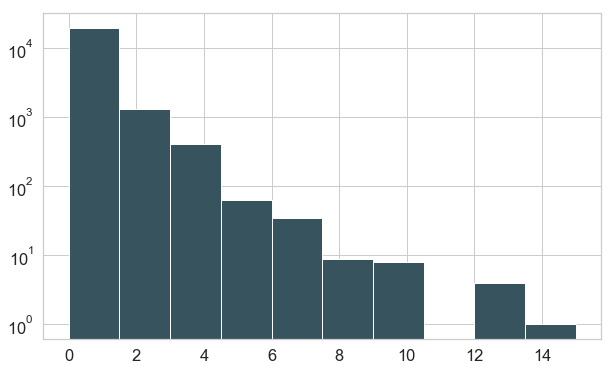

In [21]:
# Topics per document - chart
(topics
 .sum(axis=1)
 .rename('topics_per_doc')
).hist().set(yscale='log')

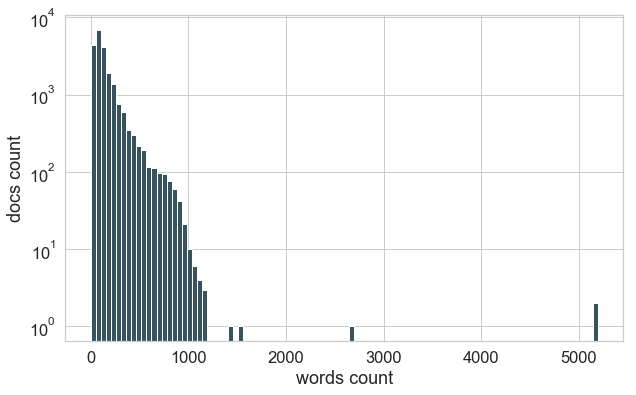

In [22]:
# words count per document:
(docs
 .assign(words_count = lambda x: (x['doc.text'] + x['doc.title']).str.strip().str.split(' ').apply(len))
 .words_count
 .hist(bins=100).set(xlabel='words count', ylabel='docs count', yscale='log')
) 
plt.show()

In [23]:
# unique words count (per pd.Series)
def get_words_count(series):
    words = set()
    series.str.split().apply(words.update)
    return(len(words))

In [24]:
# check the unique words in doc.title and doc.text:
print(get_words_count(docs['doc.title'] + ' ' + docs['doc.text']))

134890


[Text(0.5,0,'frequency, %')]

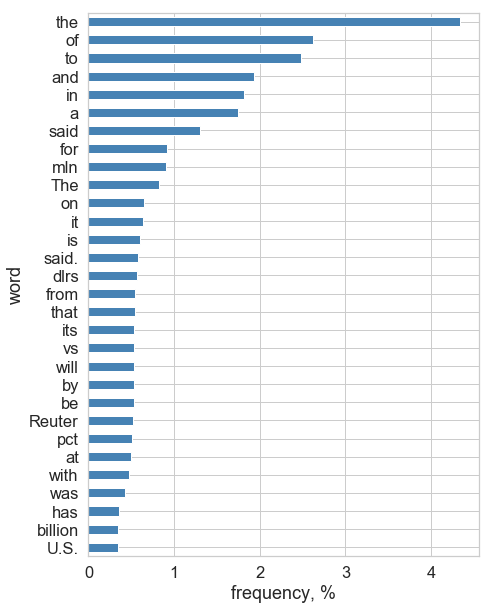

In [25]:
# but what about word frequency?  
((docs['doc.title'] + ' ' + docs['doc.text'])
 .str.split(expand=True)
 .stack()
 .rename('word')
 .reset_index()
 .groupby('word').size().rename('cnt')
 .to_frame()
 .assign(percent = lambda x: 100*x.cnt/x.cnt.sum())
 .sort_values('cnt').tail(30)
).percent.plot(kind='barh', color='steelblue', figsize=(7,10)).set(xlabel='frequency, %')

### Text Pre-processing for ML

In [26]:
def lower_case(string):
    return string.lower()

def fix_lt(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'&lt;', '<', string)

def remove_reuter(string):
    # fix the HTML-escaped less-than sign
    return re.sub(r'reuter$', '', string)

def replace_non_alphanumeric_with_space(string):
    # replace punctuation and different whitespace with space character
    return re.sub(r'[^a-z0-9 ]', ' ', string)

def strip_punctuation(string):
    # remove punctuation
    return re.sub(r'[^a-z0-9\s]', ' ', string)

def remove_stop_words(string, stop_words):
    return ' '.join([ word for word in re.split(' ', string) if not word in stop_words ])

def replace_numeric_with_literal(string):
    return re.sub(r'([0-9]+ ?)+', '<num> ', string)

def compact_whitespace(string):
    return re.sub(r'\s+', ' ', string)

def stem(string, stemmer):
    return ' '.join([ 
        stemmer.stem(word) if hasattr(stemmer, 'stem') else stemmer.lemmatize(word)
        for word in re.split(' ', string) if not word in stop_words 
    ])

In [27]:
stop_words = stopwords.words('english')

stemmer = LancasterStemmer()

In [28]:
def pre_process(string):
    s = lower_case(string)
    s = fix_lt(s)
    s = remove_reuter(s)
    s = strip_punctuation(s)
    s = remove_stop_words(s, stop_words)
    s = compact_whitespace(s)
    s = replace_numeric_with_literal(s)
    s = stem(s, stemmer)
    return s.strip()

In [29]:
# pre-processing example:
print("\n\n".join(docs.sample(1).assign(new_text = lambda x: x['doc.text'].apply(pre_process))[['doc.text', 'new_text']].values[0]))


National Medical Care Systems INc said it has named Arthur Axelrod its Chairman and Robert Kim its president.     Axelrod, who had been president, replaces U.T. Thompson III, who resigned March 1.     Kim had been a board director and director of operations for the company's primary operating subsidiary, National Health Care Systems of California, Inc.  Reuter 

nat med car system int said nam arth axelrod chairm robert kim presid axelrod presid replac u thompson ii resign march <num> kim board direct direct op company prim op subsidy nat heal car system californ int reut


In [30]:
docs['processed_text'] = (docs['doc.title'] + ' ' + docs['doc.text']).apply(pre_process)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [31]:
docs.sample(5)

,fileName,purpose,doc.title,doc.text,processed_text
pid,,,,,
14322,14,train,,WALL STREET INDICES 1200 NYSE COMPOSITE ...,wal street ind <num> nys composit <num> nys in...
18115,18,test,LOPAT INDUSTRIES &lt;LPAT.O> HAS PROFITABLE MONTH,Lopat Industries Inc said it had its first pro...,lop industry lpat profit mon lop industry int ...
1345,1,train,MAUI LAND AND PINAPPLE CO INC QUARTERLY DIVIDEND,Qtly div 12-1/2 cts vs 12-1/2 cts Pay Marc...,mau land pinappl co int quart dividend qtly di...
7154,7,train,USDA ASKS TIGHT INSECT RULES FOR GRAIN SHIPMENTS,The U.S. Agriculture Department is proposing t...,usd ask tight insect rul grain ship u agricult...
9339,9,train,COMMUNICATIONS AND CABLE INC &lt;CCAB> 1ST QTR...,Oper shr seven cts vs loss nil Oper net 98...,commun cabl int ccab <num> st qtr net op shr s...


In [32]:
print(get_words_count(docs.processed_text))

27694


[Text(0.5,0,'frequency, %')]

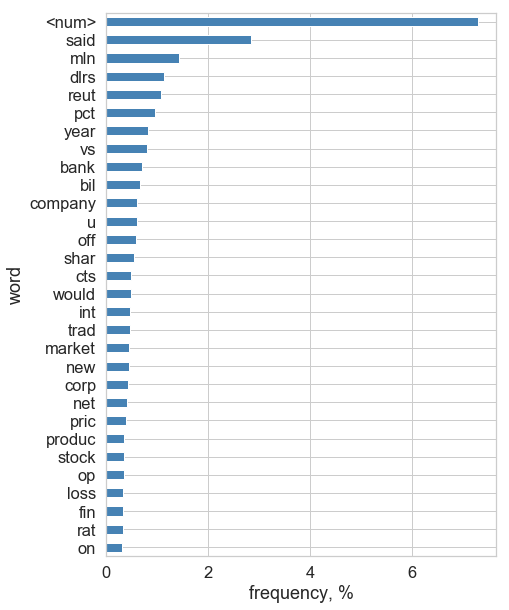

In [33]:
# but what about word frequency?  
(docs.processed_text
 .str.split(expand=True)
 .stack()
 .rename('word')
 .reset_index()
 .groupby('word').size().rename('cnt')
 .to_frame()
 .assign(percent = lambda x: 100*x.cnt/x.cnt.sum())
 .sort_values('cnt').tail(30)
).percent.plot(kind='barh', color='steelblue', figsize=(7,10)).set(xlabel='frequency, %')

In [34]:
# what if we need to filter only some topics and only docs with single topic?

# define tpoics
nice_topics = [
    'money.fx',
    'crude',
    'grain',
    'trade',
    'interest'
]

In [35]:
# now we can filter topics DF as:
nice_columns = topics.columns.isin(nice_topics) 
topics.loc[:,nice_columns].sample(3)

topic,crude,grain,interest,money.fx,trade
pid,,,,,
11929,0,0,0,0,0
13536,0,0,0,0,0
1956,0,0,0,0,0


In [36]:
# and we can get indexer to filter only rows (documents) with sum(topics)=1:
nice_docs = topics.loc[:,topics.columns.isin(nice_topics)].sum(axis=1)==1

topics[nice_docs].index.size

2566

In [37]:
# let's check:
(topics.loc[nice_docs,nice_columns]
 .assign(total_topics = lambda x: x.sum(axis=1))
 .sort_values('total_topics')       
).sample(10)

topic,crude,grain,interest,money.fx,trade,total_topics
pid,,,,,,
8677,0,0,1,0,0,1
9795,0,0,0,0,1,1
1692,1,0,0,0,0,1
3192,0,0,1,0,0,1
1709,1,0,0,0,0,1
4296,0,1,0,0,0,1
4048,0,0,0,0,1,1
3133,0,0,1,0,0,1
16366,1,0,0,0,0,1


In [38]:
# same indexer can be used on docs DF too:
docs[nice_docs].sample(5)

,fileName,purpose,doc.title,doc.text,processed_text
pid,,,,,
14270,14,train,VOLCKER SAYS FED POLICY NOT LINKED TO RATE RISE,Federal Reserve Board Chairman Paul Volcker sa...,volck say fed policy link rat ris fed reserv b...
15472,15,test,"FAO SEES LOWER GLOBAL WHEAT, GRAIN OUTPUT IN 1987",The U.N. Food and Agriculture Organisation (FA...,fao see low glob whe grain output <num> u n fo...
2417,2,train,CONSENSUS BUILDS FOR WORLD AGRICULTURAL REFORM,Top U.S. and European farm trade and governmen...,consens build world agricult reform top u euro...
21363,21,test,COASTAL &lt;CGP> RAISES OIL POSTED PRICES,Coastal Corp said that effective October 16 it...,coast cgp rais oil post pric coast corp said e...
8240,8,train,GATT MEETING HEARS PLEA FOR AFRICAN DEBT RELIEF,Debt among African countries will continue to ...,gat meet hear ple afr debt reliev debt among a...


In [39]:
# if we need to deal with less frequent words:
# total count of words in set:
get_words_count(docs[nice_docs].processed_text)

8314

In [40]:
# get 3000 least frequent words:
bad_words = (docs[nice_docs].processed_text
 .str.split(expand=True)
 .stack()
 .rename('word')
 .reset_index()
 .groupby('word').size()
 .sort_values()
 .head(3000).index.values
)

In [41]:
bad_words[:10]

array(['lien', 'legend', 'legionario', 'len', 'length', 'lentil', 'leny',
       'leonard', 'leonardo', 'leonhard'], dtype=object)

In [42]:
def replace_words(string):
    string = " ".join(np.where(np.isin(np.array(string.split()), bad_words), '<unk>', np.array(string.split())))
    return string

In [43]:
docs[nice_docs].processed_text.apply(replace_words).sample(5)

pid
8212     finland febru trad surpl <num> mln markk finla...
17274    baldrig say u want jap trad propos u secret co...
2025     yeut put cur burd taiw kore respons apprecy ta...
502      study group urg increas u oil reserv study gro...
2952     hong kong bank leav interest rat unchang hong ...
Name: processed_text, dtype: object

In [44]:
# ok, we ready to precict something now:
docs[nice_docs].groupby('purpose').size()

purpose
not-used     209
test         652
train       1705
dtype: int64

In [45]:
(docs[nice_docs]
 .join((
    topics.loc[nice_docs, nice_topics]
     .apply(lambda x: np.where(x==0, np.nan, x))
     .stack()
     .dropna()
     .reset_index()
     .set_index('pid')
     .topic
    ))
  .reindex(['purpose', 'topic', 'processed_text'], axis=1)
).sample(10) 

,purpose,topic,processed_text
pid,,,
17875,test,crude,sou kore increas duty crud import sou kore inc...
8302,train,money.fx,u treasury bak say cur within rang bet reflect...
16094,test,trade,taiw annount new round import tariff cut taiw ...
11025,train,crude,venezuel want boost refin capac venezuel stat ...
17943,test,interest,nakason sumit agr rat cut appropry prim min ya...
11392,train,grain,weath hurt yugoslav whe usd report unfav lat w...
6366,train,interest,nat westminst bank said cut bas rat <num> pct ...
21202,test,money.fx,g <num> seen fight keep cur pact intern monet ...
13404,train,money.fx,bundesbank set new repurchas tend bundesbank s...
